# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

/home/jamal/anaconda3/envs/pycutfem/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho_f = 1.0  # Density for fluid
rho_s = 1.0  # Density for solid
mu_f = 1e-3  # Viscosity for fluid
U_mean = 1.0 # Mean inflow velocity
# Lame coefficients for solid
_lambda_s = 0.5e6 # Lame's first parameter for solid
_mu_s = 2.0e6   # Lame's second parameter for solid
Re = rho_f * U_mean * D / mu_f
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
from pycutfem.utils.adaptive_mesh_ls_numba import structured_quad_levelset_adaptive
# from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 40, 40
# NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging

# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.1*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---
bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}


# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---


mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
solid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = get_domain_bitset(mesh, "edge", "ghost")
fluid_interface_domain = fluid_domain | cut_domain
solid_interface_domain = solid_domain | cut_domain
solid_ghost_edges = mesh.edge_bitset('ghost_neg') | mesh.edge_bitset('interface') | mesh.edge_bitset('ghost_both')
fluid_ghost_edges = mesh.edge_bitset('ghost_pos') | mesh.edge_bitset('interface') | mesh.edge_bitset('ghost_both')

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 
                                                'p': 1
                                                ,'vsx':1, 'vsy':1,
                                                'dx':1,'dy':1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {ghost_edges.cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of fluid elements: {fluid_domain.cardinality()}")
print(f"Number of solid elements: {solid_domain.cardinality()}")
print(f"Number of solid ghost edges: {solid_ghost_edges.cardinality()}")
print(f"Number of fluid ghost edges: {fluid_ghost_edges.cardinality()}")


=== DofHandler (CG) ===
        ux: 8961 DOFs @ offset 0
        uy: 8961 DOFs @ offset 9
         p: 2288 DOFs @ offset 18
       vsx: 2288 DOFs @ offset 22
       vsy: 2288 DOFs @ offset 26
        dx: 2288 DOFs @ offset 30
        dy: 2288 DOFs @ offset 34
  total : 29362
Number of interface edges: 46
Number of ghost edges: 90
Number of cut elements: 46
Number of fluid elements: 2113
Number of solid elements: 34
Number of solid ghost edges: 86
Number of fluid ghost edges: 98


In [5]:
dof_handler.tag_dofs_from_element_bitset("solid_zone", "ux", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("solid_zone", "uy", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("solid_zone", "p", "inside", strict=True)



dof_handler.tag_dofs_from_element_bitset("fluid_zone", "vsx", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("fluid_zone", "vsy", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("fluid_zone", "dx", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("fluid_zone", "dy", "outside", strict=True)

for zone,fields in zip( ['solid_zone', 'fluid_zone'],
                      [('ux', 'uy', 'p'), ('vsx', 'vsy', 'dx', 'dy')]):
    for field in fields:
        bcs.append(
            BoundaryCondition(field, 'dirichlet', zone, lambda x, y: 0.0)
        )
        bcs_homog.append(
            BoundaryCondition(field, 'dirichlet', zone, lambda x, y: 0.0)
        )

In [6]:
# contraining the displacement and velocity of solid to zero for cyclinder center
# 1. Define the target point.
target_point = np.array([c_x,c_y])

# 2. Get all node IDs that have a pressure DOF associated with them.
pin_dofs = dof_handler.get_field_slice('vsx')
pin_node_ids = np.array([dof_handler._dof_to_node_map[dof][1] for dof in pin_dofs])

# 3. Get the coordinates of ONLY these pressure-carrying nodes.
pin_node_coords = mesh.nodes_x_y_pos[pin_node_ids]

# 4. Find the node closest to the target point WITHIN this restricted set.
distances = np.linalg.norm(pin_node_coords - target_point, axis=1)
local_index = np.argmin(distances)

# 5. Get the global ID and actual coordinates of that specific pressure node.
closest_p_node_id = pin_node_ids[local_index]
actual_pin_coords = mesh.nodes_x_y_pos[closest_p_node_id]
print(f"Pinning pressure at the node closest to {target_point}, found at {actual_pin_coords}")
for field in ['vsx', 'vsy', 'dx', 'dy']:
    name = 'pinning'
    dof_handler.tag_dof_by_locator(
        name, field,
        locator=lambda x, y: np.isclose(x, actual_pin_coords[0]) and np.isclose(y, actual_pin_coords[1]),
        find_first=True
    )
    bcs.append(
        BoundaryCondition(field, 'dirichlet', name, lambda x, y: 0.0)
    )
    bcs_homog.append(
        BoundaryCondition(field, 'dirichlet', name, lambda x, y: 0.0)
    )


Pinning pressure at the node closest to [0.2 0.2], found at [0.1925   0.199875]


In [7]:
print(f'Total dirchlet dofs: {len(dof_handler.get_dirichlet_data(bcs))}')

Total dirchlet dofs: 9496


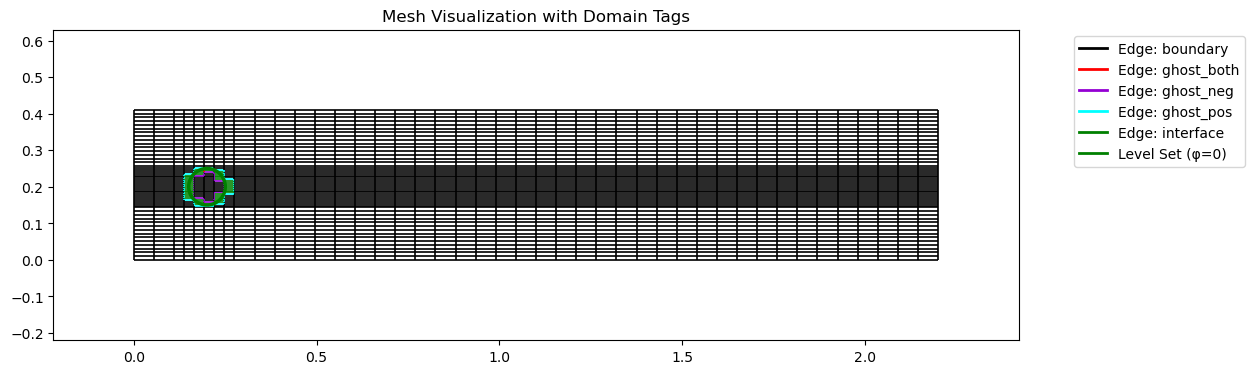

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [8]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [9]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_fluid_space = FunctionSpace(name="velocity_fluid", field_names=['ux', 'uy'],dim=1)
pressure_fluid_space = FunctionSpace(name="pressure_fluid", field_names=['p'], dim=0)
velocity_solid_space = FunctionSpace(name="velocity_solid", field_names=['vsx', 'vsy'], dim=1)
displacement_space = FunctionSpace(name="displacement", field_names=['dx', 'dy'], dim=1)
# Trial and Test functions
du_f = VectorTrialFunction(space=velocity_fluid_space, dof_handler=dof_handler)
dp_f = TrialFunction(name='trial_pressure_fluid', field_name='p', dof_handler=dof_handler)
du_s = VectorTrialFunction(space=velocity_solid_space, dof_handler=dof_handler)
ddisp_s = VectorTrialFunction(space=displacement_space, dof_handler=dof_handler)
test_vel_f = VectorTestFunction(space=velocity_fluid_space, dof_handler=dof_handler)
test_q_f = TestFunction(name='test_pressure_fluid', field_name='p', dof_handler=dof_handler)
test_vel_s = VectorTestFunction(space=velocity_solid_space, dof_handler=dof_handler)
test_disp_s = VectorTestFunction(space=displacement_space, dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
uf_k = VectorFunction(name="u_f_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
pf_k = Function(name="p_f_k", field_name='p', dof_handler=dof_handler)
uf_n = VectorFunction(name="u_f_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
pf_n = Function(name="p_f_n", field_name='p', dof_handler=dof_handler)
us_k = VectorFunction(name="u_s_k", field_names=['vsx', 'vsy'], dof_handler=dof_handler)
us_n = VectorFunction(name="u_s_n", field_names=['vsx', 'vsy'], dof_handler=dof_handler)
disp_k = VectorFunction(name="disp_k", field_names=['dx', 'dy'], dof_handler=dof_handler)
disp_n = VectorFunction(name="disp_n", field_names=['dx', 'dy'], dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.2)
theta = Constant(1.0) # Crank-Nicolson
mu_f_const = Constant(mu_f)
rho_f_const = Constant(rho_f)
rho_s_const = Constant(rho_s)
mu_s = Constant(_mu_s) # Lame's second parameter for solid
lambda_s = Constant(_lambda_s)  # Lame's first parameter for solid

uf_k.nodal_values.fill(0.0); pf_k.nodal_values.fill(0.0)
uf_n.nodal_values.fill(0.0); pf_n.nodal_values.fill(0.0)
us_k.nodal_values.fill(0.0); us_n.nodal_values.fill(0.0)
disp_k.nodal_values.fill(0.0); disp_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, uf_n, pf_n, us_n, disp_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_f_n' as separate contour plots...


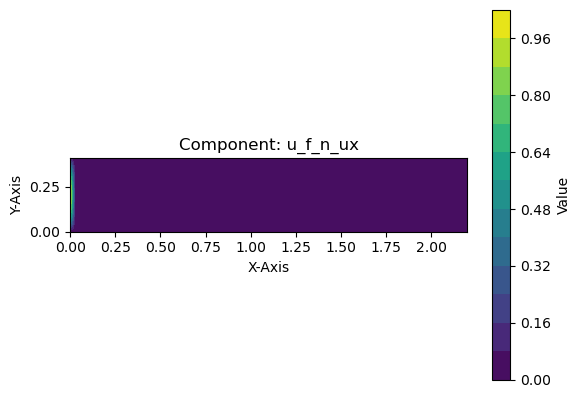

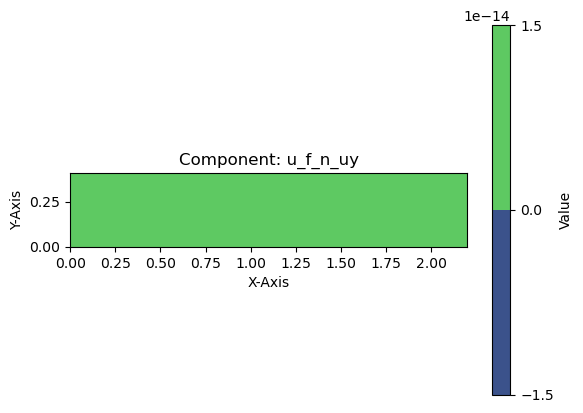

In [10]:
uf_n.plot()

In [11]:
from pycutfem.ufl.expressions import Derivative, FacetNormal, trace, Jump
n = FacetNormal()                    # vector expression (n_x, n_y)

def _dn(expr):
    """Normal derivative  n·∇expr  on an (interior) edge."""
    Dx = Derivative(expr, 1, 0)
    Dy = Derivative(expr, 0, 1)
    _ = Dx + Dy
    return n[0]*Dx + n[1]*Dy

def grad_inner(u, v):
    """⟨∂ₙu, ∂ₙv⟩  (scalar or 2‑D vector)."""
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _dn(u) * _dn(v)

    if u.num_components == v.num_components == 2: # vector
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])

    raise ValueError("grad_inner supports only scalars or 2‑D vectors.")

def hessian_inner(u, v):
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _hess_comp(u, v)

    # vector: sum component-wise
    return sum(_hess_comp(u[i], v[i]) for i in range(u.num_components))


def _hess_comp(a, b):
    return (Derivative(a,2,0)*Derivative(b,2,0) +
            2*Derivative(a,1,1)*Derivative(b,1,1) +
            Derivative(a,0,2)*Derivative(b,0,2))

dx_fluid  = dx(defined_on=fluid_interface_domain,level_set=level_set,
               metadata={"q":6, "side": "+"})               # volume
dx_solid  = dx(defined_on=solid_interface_domain,level_set=level_set,
               metadata={"q":6, "side": "-"})               # volume
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set, metadata={"q":5,'derivs': {(0,0),(0,1),(1,0)}})   # interior surface
dG_fluid       = dGhost(defined_on=fluid_ghost_edges, level_set=level_set,metadata={"q":5,'derivs': {(0,0),(0,1),(1,0),(2,0),(0,2),(1,1)}})  # ghost fluid surface
dG_solid       = dGhost(defined_on=solid_ghost_edges, level_set=level_set,metadata={"q":5,'derivs': {(0,0),(0,1),(1,0),(2,0),(0,2),(1,1)}})  # ghost solid surface

cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(10.0 * poly_order**2)      # Nitsche penalty (tweak)

def epsilon_f(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)
def epsilon_s_linear_L(disp,disp_k):
    return 0.5 * (  grad(disp) + grad(disp).T  + dot(grad(disp).T,grad(disp_k)) + dot(grad(disp_k).T,grad(disp))  ) 
def epsilon_s_linear_R(disp_k):
    """
    Right-hand side of the linearized solid strain tensor.
    """
    return 0.5 * (grad(disp_k) + grad(disp_k).T + dot(grad(disp_k).T,  grad(disp_k)) )

def sigma_s_linear_weak_L(ddisp,disp_k, grad_v_test):
    """
    Linearized solid stress tensor.
    """
    return 2.0 * mu_s * inner(epsilon_s_linear_L(ddisp, disp_k),grad_v_test) + lambda_s * trace(epsilon_s_linear_L(ddisp, disp_k))  * trace(grad_v_test)
def sigma_s_linear_weak_R(disp_k, grad_v_test):
    """
    Right-hand side of the linearized solid stress tensor.
    """
    return 2.0 * mu_s * inner(epsilon_s_linear_R(disp_k),grad_v_test) + lambda_s * trace(epsilon_s_linear_R(disp_k))  * trace(grad_v_test)

def sigma_dot_n_v(u_vec, p_scal,v_test,n):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return  mu_f * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du_f, dp_f, Jump(test_vel_f, test_vel_s),n)           # consistency
    - sigma_dot_n_v(Jump(test_vel_f, test_vel_s), test_q_f, Jump(du_f, du_s), n)           # symmetry
    + beta_N * mu_f / cell_h * dot(Jump(du_f, du_s), Jump(test_vel_f, test_vel_s))     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(uf_k, pf_k, Jump(test_vel_f, test_vel_s),n)
    - sigma_dot_n_v(Jump(test_vel_f, test_vel_s), test_q_f, Jump(uf_k, us_k), n) # I removed - test_q_f
    + beta_N * mu_f / cell_h * dot(Jump(uf_k,us_k), Jump(test_vel_f , test_vel_s))
) * dΓ

# volume -------------------fluid--------------------------------
a_vol_f = ( rho_f*dot(du_f,test_vel_f)/dt
          + theta*rho_f*dot(dot(grad(uf_k), du_f), test_vel_f)
          + theta*rho_f*dot(dot(grad(du_f), uf_k), test_vel_f)
          + theta*mu_f*inner(grad(du_f), grad(test_vel_f))
          - dp_f*div(test_vel_f) + test_q_f*div(du_f) ) * dx_fluid


r_vol_f = ( rho_f*dot(uf_k-uf_n, test_vel_f)/dt
          + theta*rho_f*dot(dot(grad(uf_k), uf_k), test_vel_f)
          + (1-theta)*rho_f*dot(dot(grad(uf_n), uf_n), test_vel_f)
          + theta*mu_f*inner(grad(uf_k), grad(test_vel_f))
          + (1-theta)*mu_f*inner(grad(uf_n), grad(test_vel_f))
          - pf_k*div(test_vel_f) + test_q_f*div(uf_k) ) * dx_fluid

# volume -------------------solid--------------------------------
a_vol_s = ( rho_s*dot(du_s,test_vel_s)/dt
          + theta*rho_s*dot(dot(grad(us_k), du_s), test_vel_s)
          + theta*rho_s*dot(dot(grad(du_s), us_k), test_vel_s)
          + theta*sigma_s_linear_weak_L(ddisp_s, disp_k, grad(test_vel_s))
           ) * dx_solid


r_vol_s = ( rho_s * dot(us_k-us_n, test_vel_s)/dt
          + theta * rho_s * dot(dot(grad(us_k), us_k), test_vel_s)
          + (1-theta) * rho_s * dot(dot(grad(us_n), us_n), test_vel_s)
          + theta * sigma_s_linear_weak_R(disp_k, grad(test_vel_s))
          + (1-theta) * sigma_s_linear_weak_R(disp_n, grad(test_vel_s))
           ) * dx_solid
# --- solid disp and solid velocity constraint --------------------------------
a_svc = (
    dot(ddisp_s, test_disp_s)/dt 
    + theta * dot( dot(grad(ddisp_s), us_k), test_disp_s)
    + theta * dot( dot(grad(disp_k), du_s) , test_disp_s)
    - theta * dot(du_s, test_disp_s)
) * dx_solid
r_svc = (    dot(disp_k-disp_n, test_disp_s)/dt 
    + theta * dot(dot(grad(disp_k), us_k), test_disp_s)
    + (1-theta) * dot(dot(grad(disp_n), us_n), test_disp_s)
    - theta * dot(us_k, test_disp_s)
    - (1-theta) * dot(us_n, test_disp_s)
) * dx_solid

# ghost stabilisation (add exactly as in your Poisson tests) --------
penalty_val = 1e-3
penalty_grad = 1e-3
penalty_hess = 1e-3
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad= Constant(penalty_grad * poly_order**2)
gamma_p  = Constant(penalty_val * poly_order**1)
gama_p_grad = Constant(penalty_grad * poly_order**1)
def g_v_f(gamma, phi_1, phi_2):
    return (
        gamma * (
            cell_h * grad_inner(jump(phi_1), jump(phi_2)) 
            + cell_h**3.0/4.0   * hessian_inner(jump(phi_1), jump(phi_2))
        )
    )
def g_p(gamma, phi_1, phi_2):
    return (
        gamma * (
            cell_h**3.0 * grad_inner(jump(phi_1), jump(phi_2)) 
        )
    )
def g_v_s(gamma, phi_1, phi_2):
    return (
        gamma * (
            cell_h**3.0 * grad_inner(jump(phi_1), jump(phi_2)) 
        )
    )
def g_disp_s(gamma, phi_1, phi_2):
    return (
        gamma * (
            cell_h * grad_inner(jump(phi_1), jump(phi_2)) 
        )
    )


a_stab = (
    (
    Constant(2.0) * mu_f_const * g_v_f(gamma_v, du_f, test_vel_f)
    + g_p(gamma_p, dp_f, test_q_f)
    ) * dG_fluid + 
    (
    rho_s_const * g_v_s(gamma_v, du_s, test_vel_s)
    + Constant(2.0) * mu_s * g_disp_s(gamma_v_grad, ddisp_s, test_disp_s)
    ) * dG_solid
)
r_stab = (
    (
    Constant(2.0) * mu_f_const * g_v_f(gamma_v, uf_k, test_vel_f)
    + g_p(gamma_p, pf_k, test_q_f)
    ) * dG_fluid + 
    (
    rho_s_const * g_v_s(gamma_v, us_k, test_vel_s)
    + Constant(2.0) * mu_s * g_disp_s(gamma_v_grad, disp_k, test_disp_s)
    ) * dG_solid
)
# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol_f + J_int + a_vol_s + a_svc + a_stab
residual_form  = r_vol_f + R_int + r_vol_s + r_svc + r_stab
# residual_form  = dot(  Constant(np.array([0.0, 0.0]),dim=1), v) * dx
# jacobian_form  = a_vol_f + a_vol_s + a_svc + a_stab
# residual_form  = r_vol_f + r_vol_s + r_svc + r_stab





In [12]:
!rm ~/.cache/pycutfem_jit/*

rm: cannot remove '/home/jamal/.cache/pycutfem_jit/__pycache__': Is a directory


In [13]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [14]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters, AdamNewtonSolver
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")

uf_k.nodal_values.fill(0.0); pf_k.nodal_values.fill(0.0)
uf_n.nodal_values.fill(0.0); pf_n.nodal_values.fill(0.0)
us_k.nodal_values.fill(0.0); us_n.nodal_values.fill(0.0)
disp_k.nodal_values.fill(0.0); disp_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, uf_n, pf_n, us_n, disp_n)

# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=36 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
)
# primary unknowns
functions      = [uf_k, pf_k, us_k, disp_k]
prev_functions = [uf_n, pf_n, us_n, disp_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

JIT cache miss → compiling _pycutfem_kernel_8aef616c76522d039538916831979b11ffa76f3ce7acc2d7ee00c61e3165e9f5.py
Precomputing geometric factors for quad elements with quad_order=6 and p=2...
points shape: (33, 2), weights shape: (33,)
JIT cache miss → compiling _pycutfem_kernel_45c7e70dad0d935d407d15745154876f2e04cd6a6e923c02bcd74131810e3117.py
JIT cache miss → compiling _pycutfem_kernel_8f8dc672cadb63e08a63c2dccef9373336da8be0bc7fb7352db24428d68ae9c9.py
JIT cache miss → compiling _pycutfem_kernel_ff287f407182d510513bfdc77dfd38b07e305613db1d300341b384be2e02bdcf.py
JIT cache miss → compiling _pycutfem_kernel_a09c5313ec77db69de86cc1906d6eff04f857490530c870e96657a02459ee547.py
JIT cache miss → compiling _pycutfem_kernel_8784bd5683d9e50faef5f77c6ac54ccbeb784e1652d60205e2166e9d4141db79.py
JIT cache miss → compiling _pycutfem_kernel_0cc0770d7c867a896608b269c5845f714015ee1c389e7c3644edc06607273b9f.py
JIT cache miss → compiling _pycutfem_kernel_212ae7d7cb8972510da8d8726db6965ae35c294fc6ed7dbaf2

SystemError: CPUDispatcher(<function kernel at 0x7f47c5cf67a0>) returned a result with an exception set

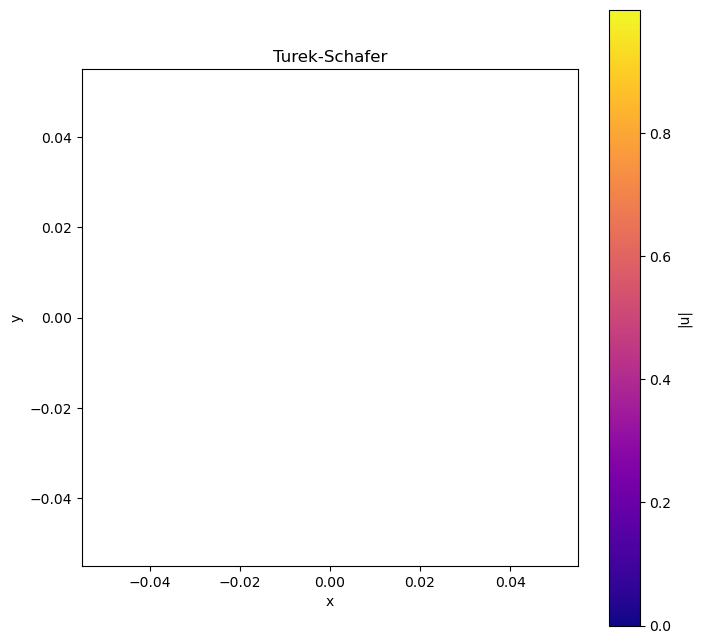

In [ ]:
uf_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Turek-Schafer",background = False)